<a href="https://colab.research.google.com/github/sayarghoshroy/COVID-19_Modelling_for_India/blob/master/covid_19_modelling_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling Covid-19 in India using SIR Model
## Author: Sayar Ghosh Roy

In [0]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path_string = "/content/drive/My Drive/COVID-19_Datasets/"
with open(path_string + 'ch.json', 'r+') as file_handler:
    data = json.load(file_handler)['timelineitems'][0]

In [0]:
# For the case of India
N = int(1e5) # total exposed population

dates = []
daily_cases = []
daily_deaths = []
total_cases =[]
total_deaths = []
total_recoveries = []

for key in data:
    if key == 'stat':
        continue
    dates.append(key)
    daily_cases.append(data[key]['new_daily_cases'])
    daily_deaths.append(data[key]['new_daily_deaths'])
    total_cases.append(data[key]['total_cases'])
    total_deaths.append(data[key]['total_deaths'])
    total_recoveries.append(data[key]['total_recoveries'])

sample_size = len(dates)

In [0]:
# computing a few sequence of values
# number of infected cases at present = Total Cases - Total Deaths - Total Recoveries = I(t)
# number of susceptible cases at present = Population Size (N) - Total Cases = S(t)

infected_present = []
susceptible_present = []

for index in range(sample_size):
    infected_present.append(total_cases[index] - total_deaths[index] - total_recoveries[index])
    susceptible_present.append(N - total_cases[index])

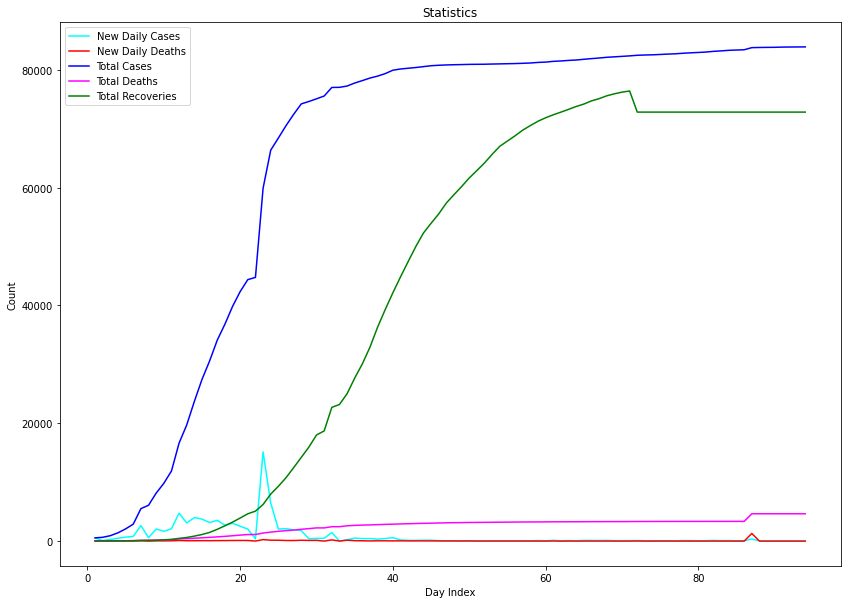

In [6]:
# data visualization
switch = 0
# To plot read out values: switch = 0
# To plot processed values: switch = 1

fig = plt.figure(figsize = (14, 10))
graph = fig.add_subplot(111)
graph.set_title('Statistics')
graph.set_xlabel('Day Index')
graph.set_ylabel('Count')
line = [x for x in range(1, sample_size + 1)]

if switch == 0:
    graph.plot(line, daily_cases, color = 'cyan', label = 'New Daily Cases')
    graph.plot(line, daily_deaths, color = 'red', label = 'New Daily Deaths')
    graph.plot(line, total_cases, color = 'blue', label = 'Total Cases')
    graph.plot(line, total_deaths, color = 'magenta', label = 'Total Deaths')
    graph.plot(line, total_recoveries, color = 'green', label = 'Total Recoveries')

elif switch == 1:
    graph.plot(line, infected_present, color = 'red', label = 'True I')
    graph.plot(line, susceptible_present, color = 'orange', label = 'True S')
    graph.plot(line, total_recoveries, color = 'green', label = 'True R')

graph.legend()
plt.show()

In [0]:
# initializing parameters
I_0 = infected_present[0]
R_0 = total_recoveries[0]
S_0 = susceptible_present[0] # everyone exposed is susceptible to infection initially

y_initial = S_0, I_0, R_0

def derivative(y, t, N, beta, gamma):
    S, I, R = y
    dS_dt = -(beta * S * I) / N
    dI_dt = (beta * S * I) / N - (gamma * I)
    dR_dt = gamma * I
    return dS_dt, dI_dt, dR_dt

def get_values(t, beta, gamma):
    # 't' being the time elapsed in number of days
    time_series = np.linspace(0, t, t)
    compute = odeint(derivative, y_initial, time_series, args = (N, beta, gamma))
    S, I, R = compute.T
    return [S, I, R]

In [0]:
# SIR model gives equations for ds/dt, dI/dt, dr/dt.
# We try to optimize parameters beta and gamma such that, at every time step,
# the computed S, I, R, matches the gold standard values
# i.e minimize L2 norm of difference between gold_standard
# and model generated values of S, I, and R

# get_values(sample_size, beta, gamma) returns the sequence of S, I, R values computed using the model

# Gradient Descent
max_iters = 100000
n_iters = 0
eta = 5 * 1e-8
delta = 2 * 1e-4

beta = 0.2966205
gamma = 0.05380502

def loss_gradients(beta, gamma):
    _, computed_I, _ = get_values(sample_size, beta, gamma)
    difference = (computed_I - np.array(infected_present))
    norm = np.dot(difference, difference)

    _, I_plus_beta, _ = get_values(sample_size, beta + delta, gamma)
    _, I_plus_gamma, _ = get_values(sample_size, beta, gamma + delta)

    _, second_I_plus_beta, _ = get_values(sample_size, beta + 2 * delta, gamma)
    _, second_I_plus_gamma, _ = get_values(sample_size, beta, gamma + 2 * delta)
    _, I_plus_beta_gamma, _ = get_values(sample_size, beta + delta, gamma + delta)
    
    del_beta = 2 * np.dot(difference, (I_plus_beta - computed_I) * (1 / delta))
    del_gamma = 2 * np.dot(difference, (I_plus_gamma - computed_I) * (1 / delta))

    hes_beta = 2 * (np.power(del_beta, 2) + np.dot(difference, (1 / (delta * delta)) * (second_I_plus_beta + computed_I - 2 * I_plus_beta)))
    hes_gamma = 2 * (np.power(del_gamma, 2) + np.dot(difference, (1 / (delta * delta)) * (second_I_plus_gamma + computed_I - 2 * I_plus_gamma)))
    hes_gamma_beta = 2 * (del_beta * del_gamma + np.dot(difference, (1 / (delta * delta)) * (I_plus_beta_gamma - I_plus_beta - I_plus_gamma + computed_I)))

    delta_loss = np.asmatrix([del_beta, del_gamma])
    hessian = np.asmatrix([[hes_beta, hes_gamma_beta], [hes_gamma_beta, hes_gamma]])
    return {'Norm': norm, 'Delta': delta_loss, 'Hessian': hessian}

losses = []
w = np.asmatrix([beta, gamma]).T

scale = 1e5

In [0]:
scale = 4 * 1e5
n_iters = 0
max_iters = 10000

while n_iters < max_iters or (len(losses) > 2 and losses[-1] > losses[-2]):
    eta *= 2
    n_iters += 1
    store = loss_gradients(w[0, 0], w[1, 0])
    loss = store['Norm']
    delta_loss = store['Delta']
    hessian = store['Hessian']
    # print(np.linalg.pinv(hessian))
    # print(delta_loss.T)
    losses.append(loss)
    change = np.linalg.pinv(hessian) @ delta_loss.T
    # eta = (change.T @ change) / (change.T @ hessian @ change)
    w = w - scale * change
    if n_iters == 100005:
        scale = 1e4

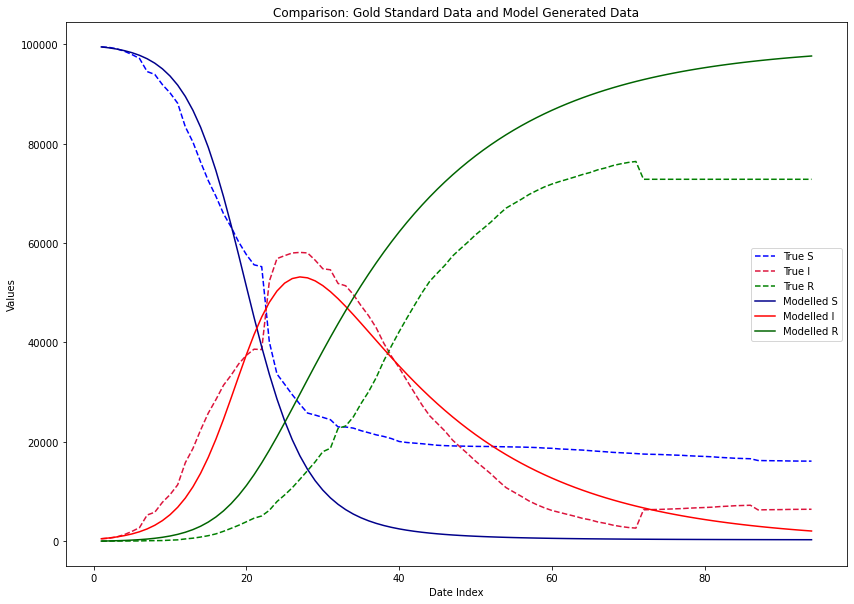

In [10]:
# Final Results
beta = w[0, 0]
gamma = w[1, 0]
computed_S, computed_I, computed_R = get_values(sample_size, beta, gamma)

fig = plt.figure(figsize = (14, 10))
graph = fig.add_subplot(111)
graph.set_title('Comparison: Gold Standard Data and Model Generated Data')
graph.set_xlabel('Date Index')
graph.set_ylabel('Values')
line = [x for x in range(1, sample_size + 1)]

graph.plot(line, susceptible_present, color = 'blue', label = 'True S', linestyle='dashed')
graph.plot(line, infected_present, color = 'crimson', label = 'True I', linestyle='dashed')
graph.plot(line, total_recoveries, color = 'green', label = 'True R', linestyle='dashed')
graph.plot(line, computed_S, color = 'darkblue', label = 'Modelled S')
graph.plot(line, computed_I, color = 'red', label = 'Modelled I')
graph.plot(line, computed_R, color = 'darkgreen', label = 'Modelled R')

graph.legend()
plt.show()

In [11]:
print("w*:", w)

w*: [[0.32180981]
 [0.0542449 ]]


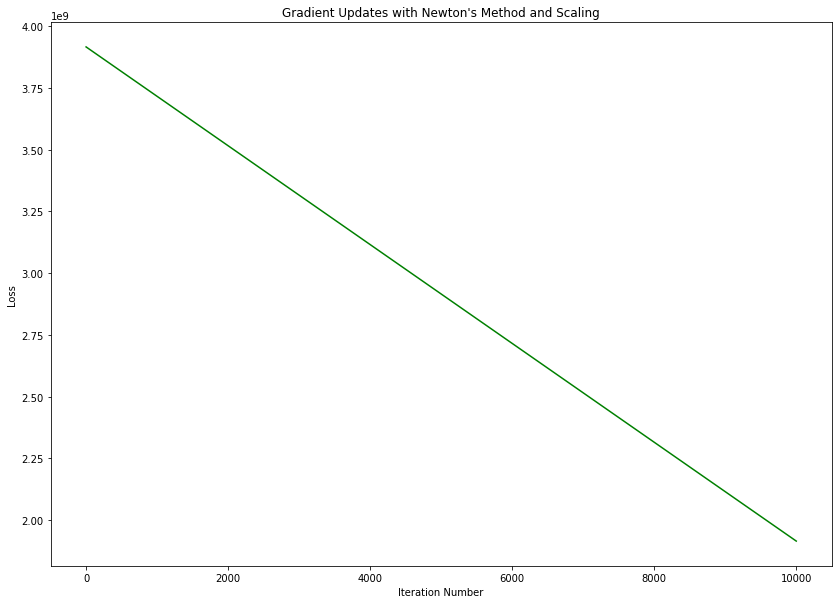

In [12]:
fig = plt.figure(figsize = (14, 10))
graph = fig.add_subplot(111)
graph.set_title('Gradient Updates with Newton\'s Method and Scaling')
graph.set_xlabel('Iteration Number')
graph.set_ylabel('Loss')
line = [x for x in range(1, len(losses) + 1)]
graph.plot(line, losses, color = 'green')
plt.show()

In [13]:
# calculating optimum go out time
computed_S, computed_I, computed_R = get_values(300, beta, gamma)
start = 1
end = 300
answer = -1

while start < end:
    mid = int((start + end) / 2)
    if computed_I[mid] <= 8:
        end = mid - 1
        answer = mid
    else:
        start = mid + 1

print("Number of Days for I(t) to reach 8:", answer)

Number of Days for I(t) to reach 8: 198


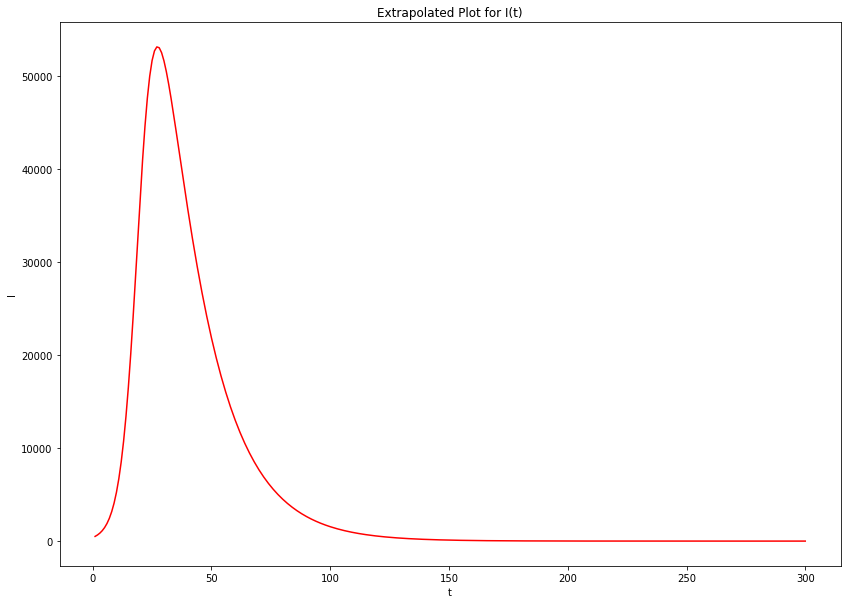

In [14]:
# extended plot for I
fig = plt.figure(figsize = (14, 10))
graph = fig.add_subplot(111)
graph.set_title('Extrapolated Plot for I(t)')
graph.set_xlabel('t')
graph.set_ylabel('I')
line = [x for x in range(1, np.shape(computed_I)[0] + 1)]
graph.plot(line, computed_I, color = 'red')
plt.show()

In [0]:
# For Italy
beta_italy = 0.00000195
gamma_italy = 0.03120240

# calculating optimum go out time
computed_S, computed_I, computed_R = get_values(1000, beta_italy, gamma_italy)

In [16]:
start = 1
end = 1000
answer = -1

while start < end:
    mid = int((start + end) / 2)
    if computed_I[mid] <= 10:
        end = mid - 1
        answer = mid
    else:
        start = mid + 1

print("Number of Days for I(t) to reach 10:", answer)

Number of Days for I(t) to reach 10: 126


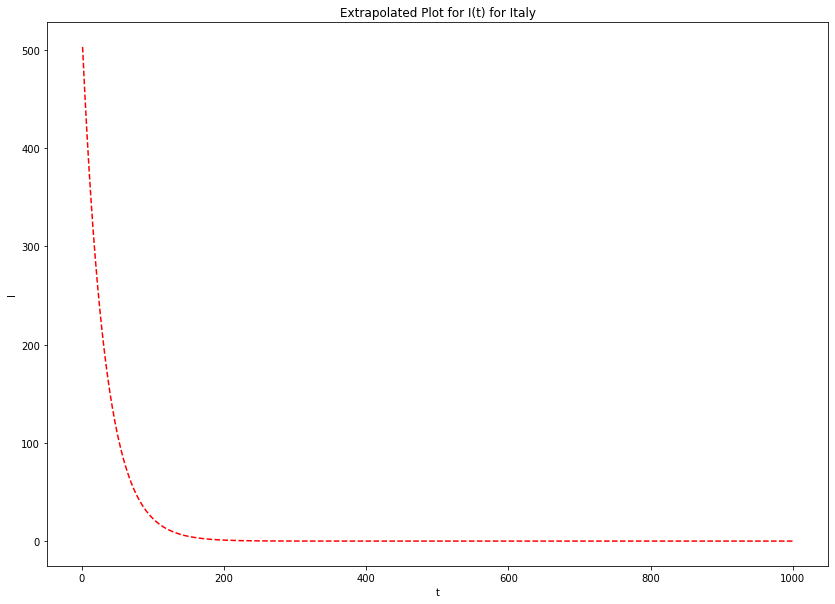

In [17]:
# extended I plot for Italy
fig = plt.figure(figsize = (14, 10))
graph = fig.add_subplot(111)
graph.set_title('Extrapolated Plot for I(t) for Italy')
graph.set_xlabel('t')
graph.set_ylabel('I')
line = [x for x in range(1, np.shape(computed_I)[0] + 1)]
graph.plot(line, computed_I, color = 'red', linestyle = 'dashed')
plt.show()

In [0]:
# Thank You ^_^